In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import warnings
warnings.filterwarnings("ignore")
from functions_ET import * 

num = 1000000
eos = "SFHo"
mns_max = 2.058838

table = h5py.File('../horizons2/population/computed_population/nsns_%i_%s_GWFAST.hdf5' %(num,eos),'r')

### --- Loading Population --- ###

print("Loading intrinsic population")
m1 = table['m1'][()]
m2 = table['m2'][()]
lamb1 = table['lamb1'][()]
lamb2 = table['lamb2'][()]
z = table['z'][()]
dL = table['dL'][()]
thv = table['thv'][()]
ra = table['ra'][()]
dec = table['dec'][()]
pol = table['pol'][()]
m_dyn = table['m_dyn'][()]
v_dyn = table['v_dyn'][()]
m_disk = table['m_disk'][()]
m_gw = table['m_gw'][()]
E_bkt = table['E_bkt'][()]
E_k_jet = table['E_k_jet'][()]
Ec = table['Ec'][()]
L_sb = table['L_sb'][()]
Eiso_sb = table['Eiso_sb'][()]
Epeak_sb = table['Epeak_sb'][()]
csi_w = 0.05; csi_s = 0.2
m_rem = m1 + m2 - m_gw - m_disk - m_dyn

print("Loading GW population")
snr_ETT = table[('snr_ETT')][()]
snr_ETL = table[('snr_ETL')][()]
snr_ETT2CE = table[('snr_ETT2CE')][()]
snr_ETL2CE = table[('snr_ETL2CE')][()]

sky_loc_ETT = table[('sky_loc_ETT')][()]
sky_loc_ETL = table[('sky_loc_ETL')][()]
sky_loc_ETT2CE = table[('sky_loc_ETT2CE')][()]
sky_loc_ETL2CE = table[('sky_loc_ETL2CE')][()]

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()]
t_kn = table['t_kn'][()]
lc_kn = table['lc_kn'][()]

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()]
grb_nu_SSC = table['grb_nu_SSC'][()]
t_grb = table['t_grb'][()]
t_grb_SSC = table['t_grb_SSC'][()]
th = table['th'][()]
lc_grb = table['lc_grb'][()]
lc_grb_SSC_NoEBL = table['lc_grb_SSC'][()]
lc_grb_SSC_NoEBL_highdens = table['lc_grb_SSC_highdens'][()]
attenuation_EBL = table['attenuation_EBL'][()]
lc_grb_SSC = lc_grb_SSC_NoEBL * attenuation_EBL[:, :, np.newaxis]
lc_grb_SSC_highdens = lc_grb_SSC_NoEBL_highdens * attenuation_EBL[:, :, np.newaxis]

print("Loading EM population (GRB prompt)")
bol_fluence_prompt = table['bol_fluence_prompt'][()]
bol_fluence_prompt_tot = table['bol_fluence_prompt_tot'][()]

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


In [2]:
### --- Weights --- ###

#Viewing angle
w_thv = np.sin(thv)

#m1 and m2
w_m1,w_m2 = mass_colombo22(m1,m2)

#Redshift z
r0BNS = 347/1.85
r0BNS_high = (347+536)/1.85
r0BNS_low = (347-256)/1.85 

w_z, w_z_high, w_z_low = redshift_weight(z,r0BNS,r0BNS_high,r0BNS_low)

#Total
w = w_m1 * w_m2 * w_z * w_thv
w_high = w_m1 * w_m2 * w_z_high * w_thv
w_low = w_m1 * w_m2 * w_z_low * w_thv

#Monte Carlo normalization
C_mc, C_mc_high, C_mc_low = monte_carlo_normalization(w,w_high,w_low,r0BNS,r0BNS_high,r0BNS_low)


In [3]:
### --- Limiting Thresholds --- ###
print("COUNTERPART SEARCH (GW subthreshold)")

lim_snr = 12.

lim_kn = np.array([26.,24.4,21.])

lim_grb = np.asarray([1.e-2,1.5e-4,1.5e-6])

lim_prompt_fermi = 3.09e-7
duty_fermi = 0.6
duty_CTA = 0.07

#GW
print("Computing GW limiting thresholds")

gw_det_ET = snr_ETT>= lim_snr
sky_loc_ET = sky_loc_ETT

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det[:,j] = kn_peak_APP <= lim_kn[j]
kn_det_all = np.max(kn_det, axis = 1)
kn_det_g = kn_det[:,0]
kn_det_z = kn_det[:,1]
kn_det_J = kn_det[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:,j] = grb_peak[:,j] >= lim_grb[j]
grb_det_all = np.max(grb_det, axis = 1)
grb_det_radio = grb_det[:,0]
grb_det_optic = grb_det[:,1]
grb_det_x = grb_det[:,2]

#SSC
print("Computing SSC limiting thresholds")

det_SSC = np.zeros([num, len(grb_nu_SSC)])
det_SSC_highdens = np.zeros([num, len(grb_nu_SSC)])

# Determine the hemisphere for each event based on the declination of the event
emispheres = determine_emisphere(dec)

# Calculate sensitivities for both bands and both hemispheres at once
sensitivity_01 = sensitivity_CTA_vectorized(emispheres, "0.1", t_grb_SSC)
sensitivity_1 = sensitivity_CTA_vectorized(emispheres, "1", t_grb_SSC)

# Apply sensitivity thresholds to detect events
mask_01 = lc_grb_SSC[:, 1, :] > sensitivity_01  # Broadcasting comparison
mask_1 = lc_grb_SSC[:, 2, :] > sensitivity_1    # Broadcasting comparison
mask_01_highdens = lc_grb_SSC_highdens[:, 1, :] > sensitivity_01  # Broadcasting comparison
mask_1_highdens = lc_grb_SSC_highdens[:, 2, :] > sensitivity_1    # Broadcasting comparison

# Use np.any along the time dimension to find detected events
det_SSC[:, 1] = np.any(mask_01, axis=1)
det_SSC[:, 2] = np.any(mask_1, axis=1)
det_SSC_highdens[:, 1] = np.any(mask_01_highdens, axis=1)
det_SSC_highdens[:, 2] = np.any(mask_1_highdens, axis=1)

# Final detection mask
grb_det_SSC_CTA = np.max(det_SSC, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
grb_det_SSC_CTA_highdens = np.max(det_SSC_highdens, axis=1)  # Mask of 0 or 1, depending on detection in at least one band

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi = bol_fluence_prompt_tot >= lim_prompt_fermi

COUNTERPART SEARCH (GW subthreshold)
Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing SSC limiting thresholds
Computing GRB PROMPT limiting thresholds


In [4]:
### --- Computing detection Rates --- ###

x = np.sort(z)
s = np.argsort(z)

#y = np.sort(sky_loc_ET)
#t = np.argsort(sky_loc_ET)

#ALL NSNS
cum_tot = C_mc*np.cumsum(w[s])
cum_tot_high = C_mc_high*np.cumsum(w_high[s])
cum_tot_low = C_mc_low*np.cumsum(w_low[s])

#cum_tot_sky = C_mc*np.cumsum(w[t])

#GW
cum_gw_ET = C_mc*np.cumsum(w[s]*gw_det_ET[s])
cum_gw_ET_high = C_mc_high*np.cumsum(w_high[s]*gw_det_ET[s])
cum_gw_ET_low = C_mc_low*np.cumsum(w_low[s]*gw_det_ET[s])
cum_gw_ET_sky10 = C_mc*np.cumsum(w[s]*gw_det_ET[s]*(sky_loc_ET[s]<10))
cum_gw_ET_sky1000 = C_mc*np.cumsum(w[s]*gw_det_ET[s]*(sky_loc_ET[s]<1000))
cum_gw_ET_sky = C_mc*np.cumsum(w[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_ET_high_sky = C_mc_high*np.cumsum(w_high[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_ET_low_sky = C_mc_low*np.cumsum(w_low[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))

cum_gw_ET_norm = cum_gw_ET/cum_gw_ET[-1]


#KN
#cum_kn =  C_mc*np.cumsum(w[s]*kn_det_all[s]) 
cum_gw_kn = C_mc*np.cumsum(w[s]*kn_det_all[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_high = C_mc_high*np.cumsum(w_high[s]*kn_det_all[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_low = C_mc_low*np.cumsum(w_low[s]*kn_det_all[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_high = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_high_sky = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low_sky = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_sky = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 

cum_gw_kn_g_norm = cum_gw_kn_g/cum_gw_kn_g[-1]

#GRB AFTERGLOW
#cum_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s])  
cum_gw_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))

cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))  
cum_gw_grb_radio_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))  
cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))
  
cum_gw_grb_radio_sky =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_ET[s]*(sky_loc_ET[s]<100)*(m_rem[s]>1.2*mns_max)) 
cum_gw_grb_radio_high_sky =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max))
cum_gw_grb_radio_low_sky =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max)) 

cum_gw_grb_radio_norm = cum_gw_grb_radio/cum_gw_grb_radio[-1]

#SSC
cum_gw_SSC_CTA =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))
cum_gw_SSC_CTA_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))
cum_gw_SSC_CTA_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))

cum_gw_SSC_CTA_sky =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max))
cum_gw_SSC_CTA_high_sky =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max))
cum_gw_SSC_CTA_low_sky =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max))

cum_gw_SSC_CTA_norm = cum_gw_SSC_CTA/cum_gw_SSC_CTA[-1]
    
#GRB PROMPT 
#cum_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]) 
cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_ET[s]*(m_rem[s]>1.2*mns_max))
cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det_ET[s])
cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det_ET[s]) 

cum_gw_fermi_sky = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max))
cum_gw_fermi_high_sky = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max))
cum_gw_fermi_low_sky = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*(m_rem[s]>1.2*mns_max))

cum_gw_fermi_norm = cum_gw_fermi/cum_gw_fermi[-1]

Plotting detection rates


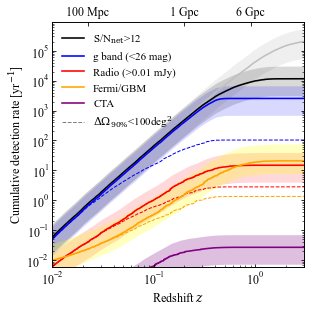

In [5]:
### --- Plotting detection Rates --- ###
print("Plotting detection rates")

#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=4.5,4.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False

#gs_kw = dict(width_ratios=[1, 1])
fig1,ax = plt.subplots(1,1) 
skip = 30000
ax.loglog(x,cum_tot,c='silver',linewidth=1.6,zorder=1)
ax.loglog(x,cum_gw_ET,c='black',linestyle='-',linewidth=1.6,zorder=1,label = "S/N$_\mathrm{net}$>12")
ax.loglog(x,cum_gw_kn_g,c='blue',linewidth=1.6,zorder=1,label="g band (<26 mag)")
ax.loglog(x,cum_gw_kn_g_sky,c='blue',ls='--',linewidth=1.,zorder=1)
ax.loglog(x,cum_gw_grb_radio,c='red',linewidth=1.6,zorder=1,label="Radio (>0.01 mJy)")
ax.loglog(x,cum_gw_grb_radio_sky,c='red',linewidth=1.,zorder=1,ls='--')
ax.loglog(x,cum_gw_fermi*duty_fermi,ls="-",c='orange',linewidth=1.6,zorder=1,label=r"Fermi/GBM")
ax.loglog(x,cum_gw_fermi_sky*duty_fermi,ls="--",c='orange',linewidth=1.,zorder=1)
ax.loglog(x,cum_gw_SSC_CTA*duty_CTA,c='purple',linewidth=1.6,zorder=1,label="CTA")
ax.fill_between(x[::10],cum_tot_high[::10],cum_tot_low[::10],color='silver',alpha=0.25,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_ET_high[::skip],cum_gw_ET_low[::skip],color='black',alpha=0.15,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_kn_g_high[::skip],cum_gw_kn_g_low[::skip],color='blue',alpha=0.15,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_grb_radio_high[::skip],cum_gw_grb_radio_low[::skip],color='red',alpha=0.15,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_fermi_high[::skip]*duty_fermi,cum_gw_fermi_low[::skip]*duty_fermi,color='yellow',alpha=0.25,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_SSC_CTA_high[::skip]*duty_CTA,cum_gw_SSC_CTA_low[::skip]*duty_CTA,color='purple',alpha=0.25,edgecolor="None",zorder=1)

perc = 0.9
xgw = np.interp(perc,cum_gw_ET_norm[::skip],x[::skip])
ygw = np.interp(np.interp(perc,cum_gw_ET_norm[::skip],x[::skip]),x[::skip],cum_gw_ET[::skip])
xkn = np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip])
ykn = np.interp(np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip]),x[::skip],cum_gw_kn_g[::skip])
xfermi = np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip])
yfermi = np.interp(np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip]),x[::skip],cum_gw_fermi[::skip]*duty_fermi)
xgrb = np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip])
ygrb = np.interp(np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip]),x[::skip],cum_gw_grb_radio[::skip])
xssc = np.interp(perc,cum_gw_SSC_CTA_norm[::skip],x[::skip])
yssc = np.interp(np.interp(perc,cum_gw_SSC_CTA_norm[::skip],x[::skip]),x[::skip],cum_gw_SSC_CTA[::skip]*duty_CTA)

ax.axvline(x = 7, color = 'grey',ls='--',linewidth=1.,label="$\Delta\Omega_{90\%}$<100deg$^2$")

ylim = (0.006,9.e5)
xlim = (0.01,3.)

ax.legend(loc=2,frameon=False,prop={'size': 11})
ax.set_xlabel('Redshift $z$',size=12)
ax.set_ylabel(r'Cumulative detection rate [yr$^{-1}$]',size=12)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(xlim)
ax.set_xticklabels(('0.01','0.1'),size=12)
ax.minorticks_on()
#ax.legend(prop={'size': 11},ncol=2)
ax2 = ax.twiny()
ax2.set_xlim(xlim)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.minorticks_off()
ax2.set_xticks([0.02225,0.198,0.9045])
ax2.set_xticklabels(('100 Mpc','1 Gpc','6 Gpc'),size=12)

ax.tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
#ax[0].tick_params(right=True,direction='inout',which='both',labelsize=11)
ax2.tick_params(direction='in',which='both',zorder=2)
ax.yaxis.labelpad = 0.1

ax.set_yscale('log')
ax.set_xscale('log')